# Get BFCs from the list of annotated commits
They will be stored in `BFCs['estimated']`

In [297]:
import os
import pandas as pd

annotations_dir = "comparison-3"
annotations_dir = "commit-annotator"
reviews_dir = "comparison-3"

def get_BFCs(results_df):
    df = results_df[['hash', 'bfc']]
    return df

def read_csv_from_dir(dirname, filename):
    results = pd.read_csv(os.path.join('..', dirname, filename))
    return results
    
results_A = read_csv_from_dir(annotations_dir, 'annotations_Michel.csv')
results_B = read_csv_from_dir(annotations_dir, 'annotations_Abhishek.csv')
results_C = read_csv_from_dir(annotations_dir, 'annotations_David.csv')

BFCs_A = get_BFCs(results_A)
BFCs_B = get_BFCs(results_B)
BFCs_C = get_BFCs(results_C)

BFCs = pd.merge(BFCs_A, BFCs_B, on='hash', how='inner', suffixes=('A', 'B'))

BFCs = pd.merge(BFCs, BFCs_C, on='hash', how='inner', suffixes=('', 'C'))
BFCs = BFCs[['hash', 'bfcA', 'bfcB', 'bfc']]
BFCs = BFCs.rename(columns={'bfc': 'bfcC'})

In [317]:
BFCs_R = read_csv_from_dir(reviews_dir, 'review_jesus.csv')
print(len(BFCs_R))
BFCs = pd.merge(BFCs, BFCs_R, on='hash', how='left')
BFCs['bfcR'] = BFCs['bfc']
BFCs = BFCs[['hash', 'bfcA', 'bfcB', 'bfcC', 'bfcR']]

125


In [299]:
import math

def estimation(A, B, C, R):
    if math.isnan(R):
        return round((A + B + C) / 3)
    else:
        return R
BFCs['estimation'] = BFCs.apply(lambda row: estimation(row['bfcA'], row['bfcB'], row['bfcC'], row['bfcR']), axis=1) 

In [300]:
BFCs['estimation'].value_counts()

estimation
0.0    697
4.0    184
3.0     11
2.0     10
1.0      9
Name: count, dtype: int64

# Get commits in LTS branches

In [301]:
LTS_commits = pd.read_csv('upstream_commits.csv', converters={'branch': str, 'minor': str})
LTS_commits['hash'] = LTS_commits['commit'].str[:10]
LTS_commits[['branch_major', 'branch_minor']] = LTS_commits['branch'].str.split('.', expand=True)
LTS_commits['branch'] = LTS_commits['branch_major'] + '.' + LTS_commits['branch_minor'].str.zfill(2)
LTS_commits['minor'] = LTS_commits['minor'].str.zfill(3)
LTS_commits.sort_values(['branch_major','branch_minor'], inplace=True)
print(f"Upstream commits found: {len(LTS_commits)}")
print(f"Unique upstream commits found: {len(LTS_commits['hash'].unique())}")
LTS_commits

Upstream commits found: 277460
Unique upstream commits found: 90895


,branch,minor,commit,hash,branch_major,branch_minor
204400,4.01,001,15bf722e6f6c0b884521a0363204532e849deb7f,15bf722e6f,4,1
204401,4.01,001,90f91b129810c3f169e443252be30ed7c0130326,90f91b1298,4,1
204402,4.01,001,0d0cef6183aec0fb6d0c9f00a09ff51ee086bbe2,0d0cef6183,4,1
204403,4.01,001,692c062e7c282164fd7cda68077f79dafd176eaf,692c062e7c,4,1
204404,4.01,001,7e730c7f3d1f39c25cf5f7cf70c0ff4c28d7bec7,7e730c7f3d,4,1
...,...,...,...,...,...,...
9572,6.06,009,0913445082496c2b29668ee26521401b273838b8,0913445082,6,6
9573,6.06,009,686c4a5a42635e0d2889e3eb461c554fd0b616b4,686c4a5a42,6,6
9574,6.06,009,6376a824595607e99d032a39ba3394988b4fce96,6376a82459,6,6
9575,6.06,009,4472edf63d6630e6cf65e205b4fc8c3c94d0afe5,4472edf63d,6,6


# Some analysis of upstream commits by branch

In [370]:
#LTS_counts = LTS_commits.groupby(['branch', 'minor']).size()
LTS_counts = LTS_commits.groupby(['branch', 'minor']).size().reset_index(name='count')
#display(LTS_counts.head(100))

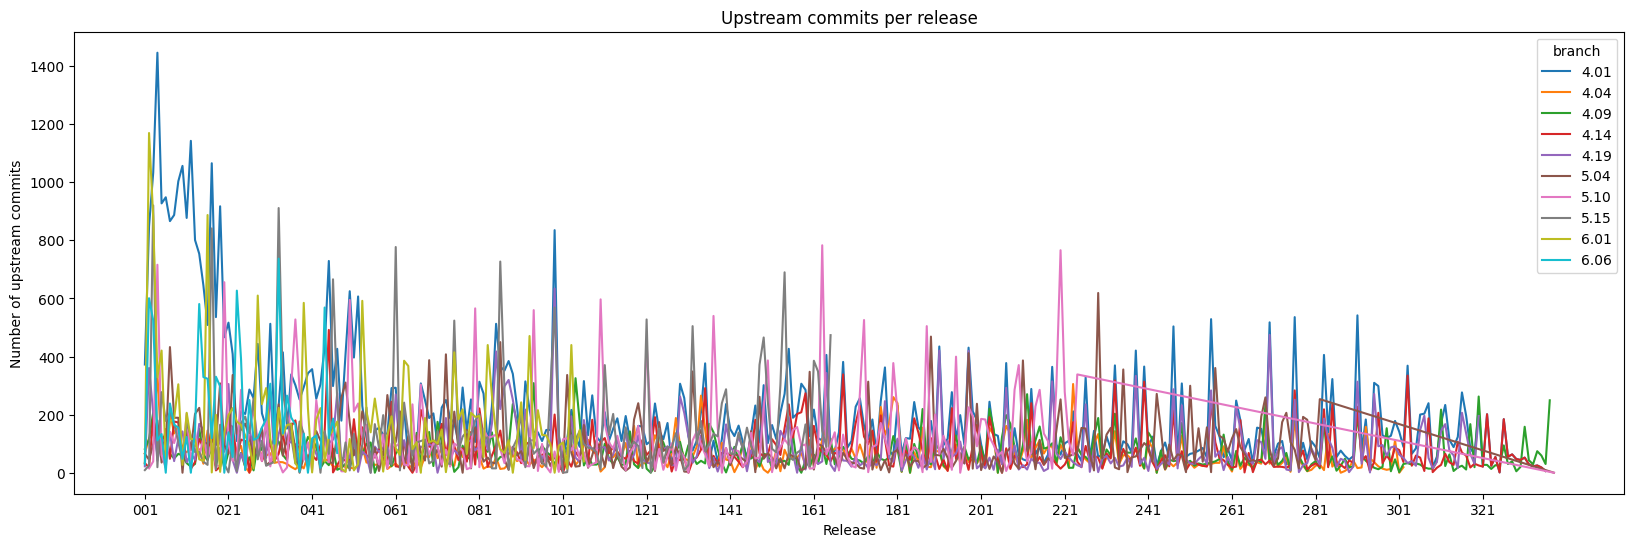

In [304]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 6))
lp = sns.lineplot(data=LTS_counts, x='minor', y='count', hue='branch')
plt.xlabel('Release')
plt.ylabel('Number of upstream commits')
plt.title('Upstream commits per release')
x_ticks = LTS_counts['minor'].unique()[::20]
plt.xticks(range(0,len(x_ticks)*20,20), x_ticks)
plt.show()

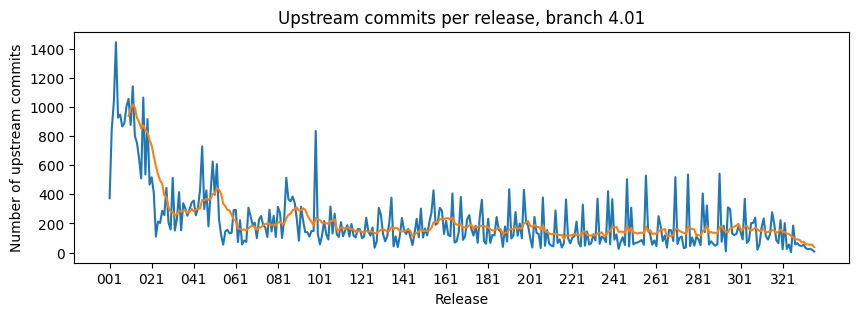

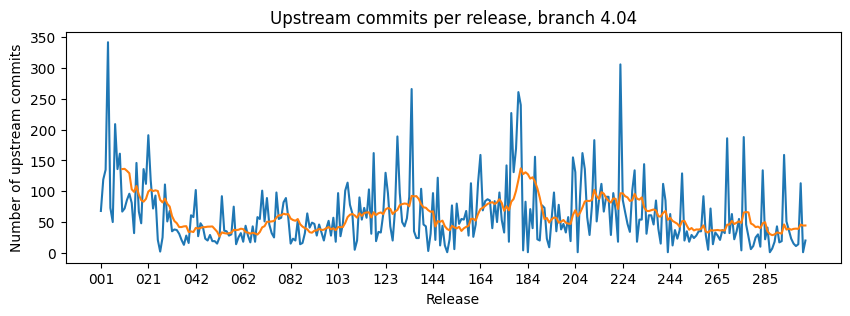

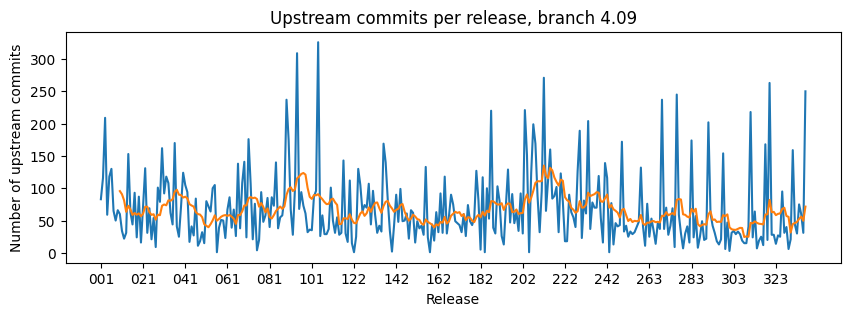

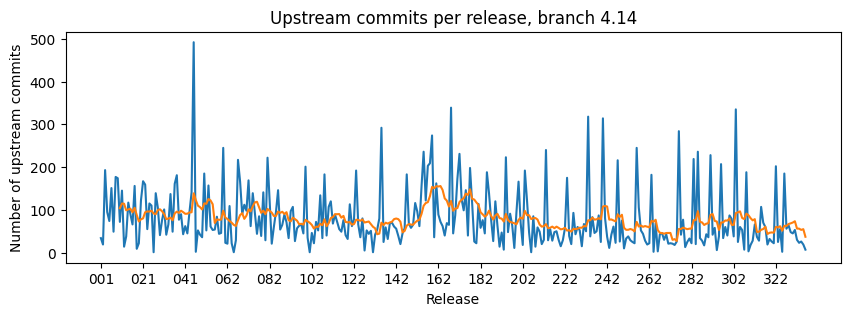

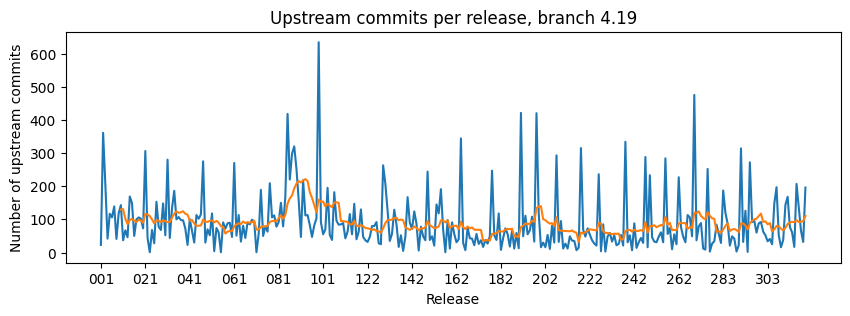

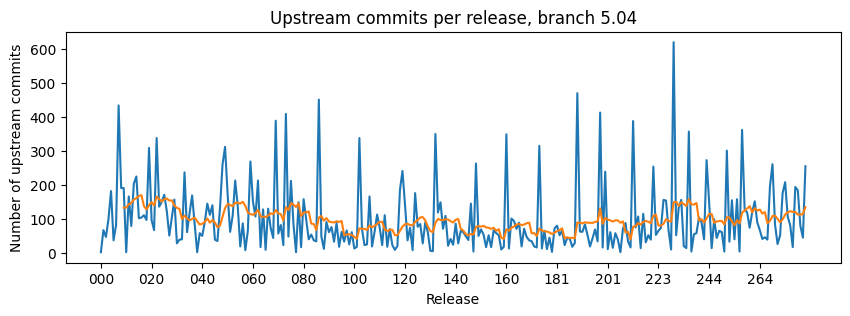

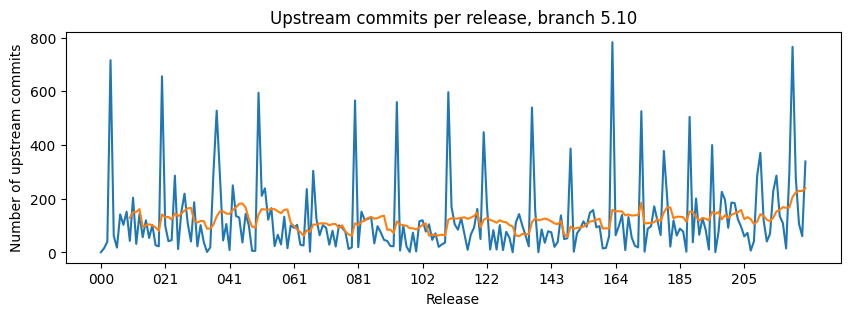

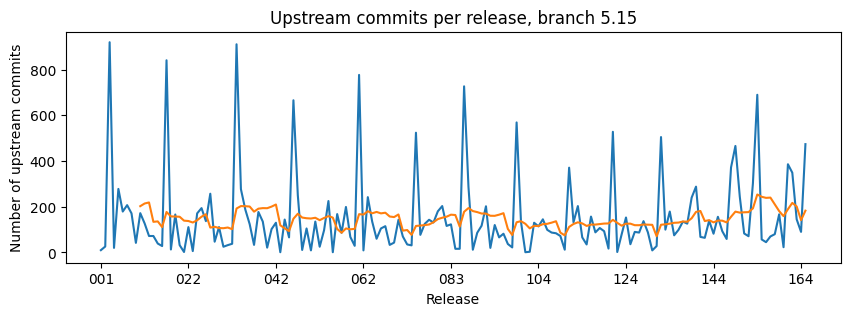

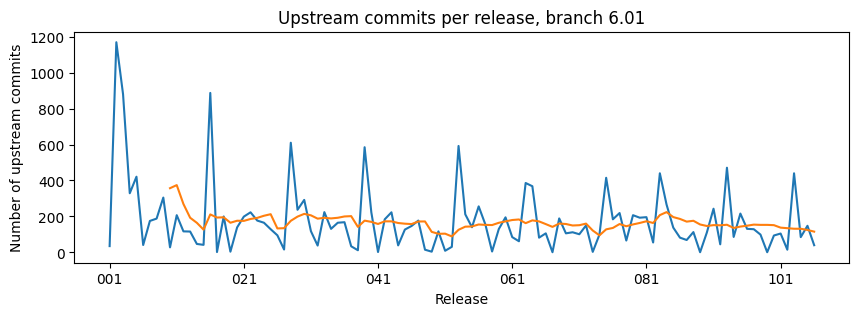

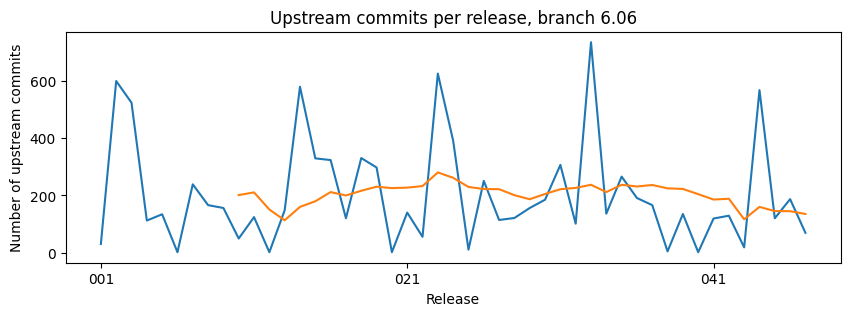

In [413]:
pd.options.mode.copy_on_write = True
for branch in LTS_counts['branch'].unique():
    branch_counts = LTS_counts[LTS_counts['branch'] == branch]
    branch_counts['mean'] = branch_counts['count'].rolling(10).mean()
    plt.figure(figsize=(10, 3))
    sns.lineplot(data=branch_counts, x='minor', y='count')
    sns.lineplot(data=branch_counts, x='minor', y='mean')
    plt.xlabel('Release')
    plt.ylabel('Number of upstream commits')
    plt.title(f'Upstream commits per release, branch {branch}')
    x_ticks = branch_counts['minor'].unique()[::20]
    plt.xticks(range(0,len(x_ticks)*20,20), x_ticks)
    #plt.show()
    plt.savefig(os.path.join("figs", f"upstream_commits_release_{branch}.eps"))

In [421]:
LTS_dates = pd.read_csv(os.path.join('results', 'release_dates.csv'),
                        converters={'branch': str, 'minor': str})
LTS_dates[['branch_major', 'branch_minor']] = LTS_dates['branch'].str.split('.', expand=True)
LTS_dates['branch'] = LTS_dates['branch_major'] + '.' + LTS_dates['branch_minor'].str.zfill(2)
LTS_dates['minor'] = LTS_dates['minor'].str.zfill(3)
LTS_counts_date = pd.merge(LTS_counts, LTS_dates, on=['branch', 'minor'], how='left')
LTS_counts_date['month'] = LTS_counts_date['date'].str[0:7]
#LTS_counts_date

In [406]:
LTS_counts_month = LTS_counts_date.groupby(['branch', 'month'])['count'].sum().reset_index()
LTS_counts_month

,branch,month,count
0,4.01,2015-06,373
1,4.01,2015-07,1881
2,4.01,2015-08,3320
3,4.01,2015-09,2756
4,4.01,2015-10,3075
...,...,...,...
565,6.06,2024-04,1044
566,6.06,2024-05,593
567,6.06,2024-06,1330
568,6.06,2024-07,572


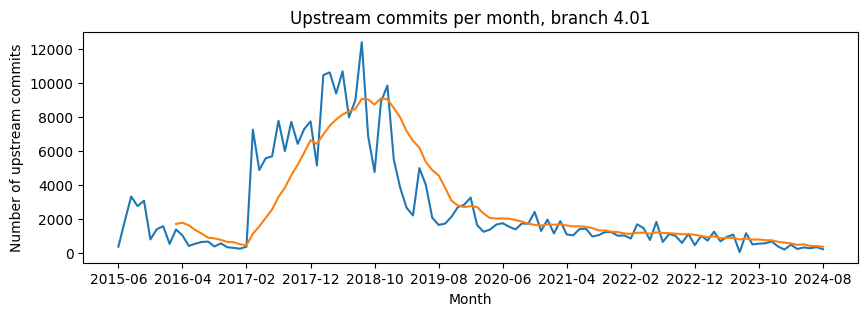

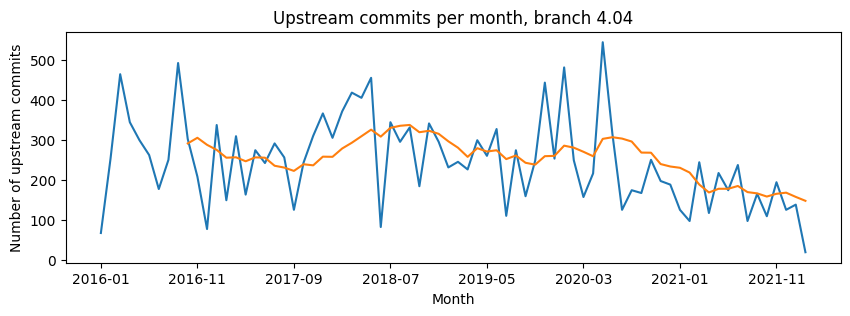

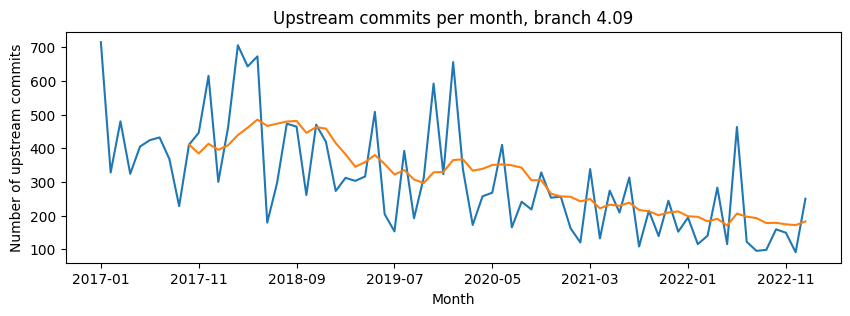

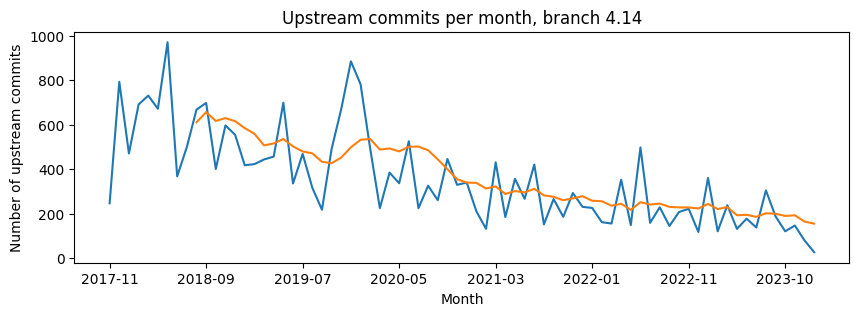

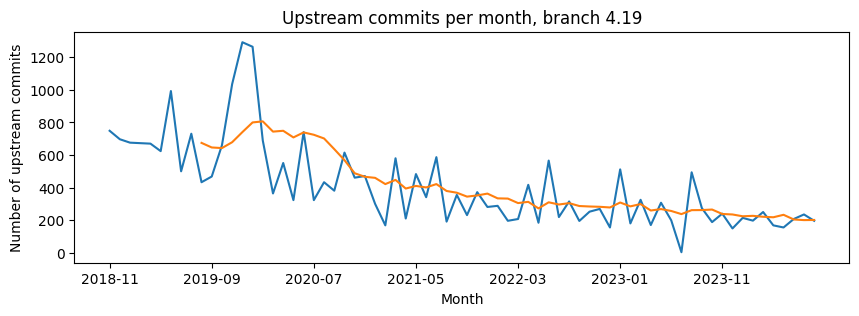

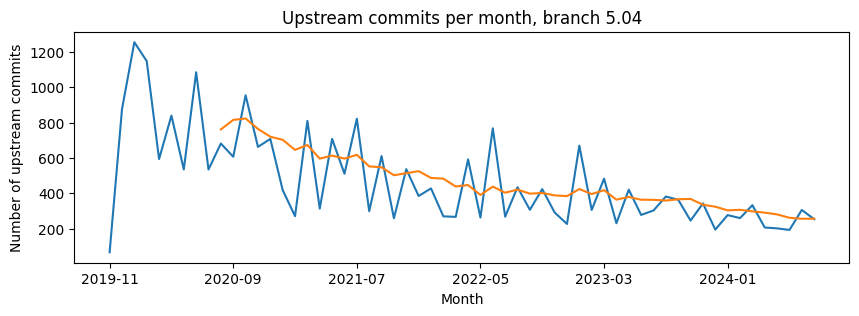

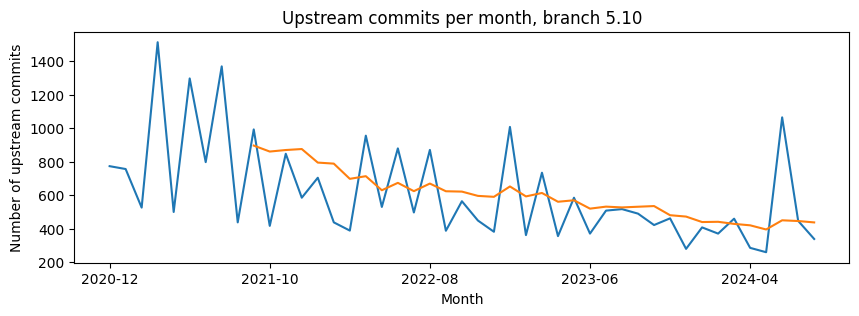

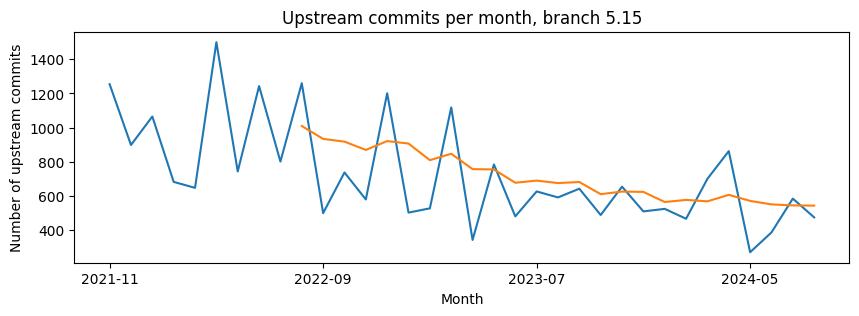

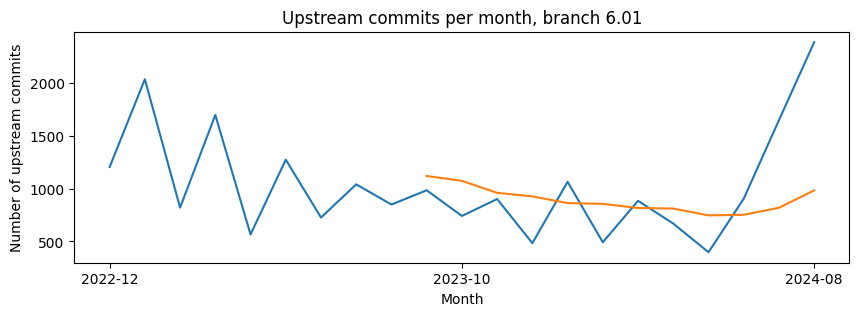

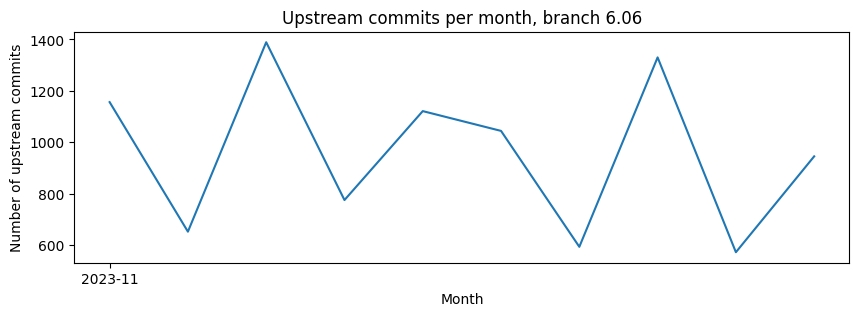

In [412]:
for branch in LTS_counts_month['branch'].unique():
    branch_counts = LTS_counts_month[LTS_counts_month['branch'] == branch]
    branch_counts['mean'] = branch_counts['count'].rolling(10).mean()
    plt.figure(figsize=(10, 3))
    sns.lineplot(data=branch_counts, x='month', y='count')
    sns.lineplot(data=branch_counts, x='month', y='mean')
    plt.xlabel('Month')
    plt.ylabel('Number of upstream commits')
    plt.title(f'Upstream commits per month, branch {branch}')
    x_ticks = branch_counts['month'].unique()[::10]
    plt.xticks(range(0,len(x_ticks)*10,10), x_ticks)
    #plt.show()
    plt.savefig(os.path.join("figs", f"upstream_commits_month_{branch}.eps"))

# Merge and analyze annotated commits found in LTS branches

In [306]:
LTS_annotated = pd.merge(LTS_commits, BFCs, on='hash', how='left')
#LTS_annotated['estimation'].value_counts()

In [307]:
commit_url = "https://git.kernel.org/pub/scm/linux/kernel/git/torvalds/linux.git/commit/?id={hash}"

LTS_annotated = LTS_annotated[LTS_annotated['estimation'].notna()]
LTS_annotated['link'] = LTS_annotated['commit'].apply(lambda hash: "<a href='" + commit_url.format(hash=hash) + "'>Link</a>")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
#LTS_annotated

In [308]:
bfc_counts = LTS_annotated.groupby('branch')['estimation'].value_counts()
bfc_fractions = LTS_annotated.groupby('branch')['estimation'].value_counts(normalize=True)
display(bfc_counts, bfc_fractions)

branch  estimation
4.01    4.0           57
        0.0           24
        1.0            4
        2.0            2
        3.0            2
4.09    4.0           20
        0.0            5
        1.0            1
        2.0            1
        3.0            1
4.14    4.0           26
        0.0            8
        1.0            2
        2.0            1
        3.0            1
4.19    4.0           31
        0.0           16
        1.0            2
        2.0            1
        3.0            1
5.04    4.0           40
        0.0           20
        1.0            2
        2.0            2
        3.0            1
5.10    4.0           64
        0.0           27
        1.0            4
        2.0            2
        3.0            1
5.15    4.0           92
        0.0           42
        1.0            4
        2.0            2
        3.0            1
6.01    0.0           14
        4.0            9
        1.0            1
        2.0            1
      

branch  estimation
4.01    4.0           0.640449
        0.0           0.269663
        1.0           0.044944
        2.0           0.022472
        3.0           0.022472
4.09    4.0           0.714286
        0.0           0.178571
        1.0           0.035714
        2.0           0.035714
        3.0           0.035714
4.14    4.0           0.684211
        0.0           0.210526
        1.0           0.052632
        2.0           0.026316
        3.0           0.026316
4.19    4.0           0.607843
        0.0           0.313725
        1.0           0.039216
        2.0           0.019608
        3.0           0.019608
5.04    4.0           0.615385
        0.0           0.307692
        1.0           0.030769
        2.0           0.030769
        3.0           0.015385
5.10    4.0           0.653061
        0.0           0.275510
        1.0           0.040816
        2.0           0.020408
        3.0           0.010204
5.15    4.0           0.652482
        0.0         

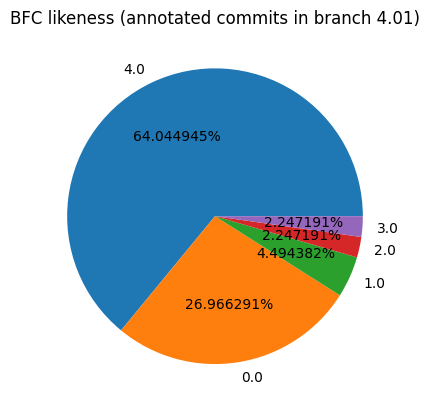

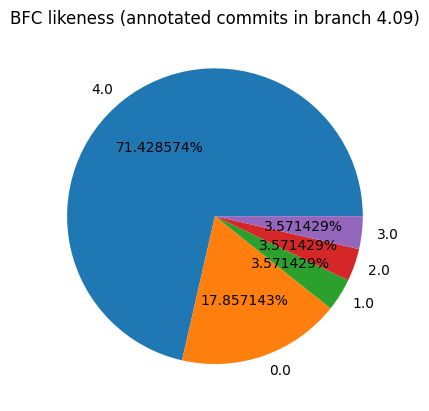

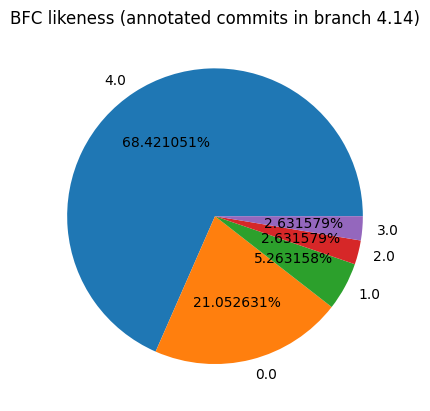

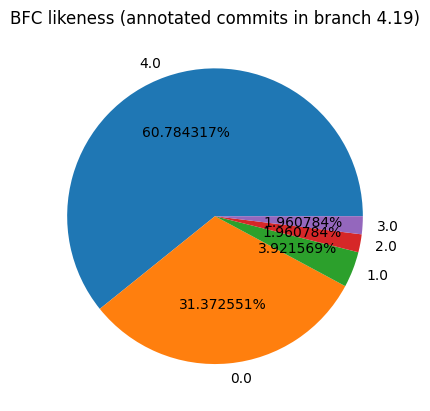

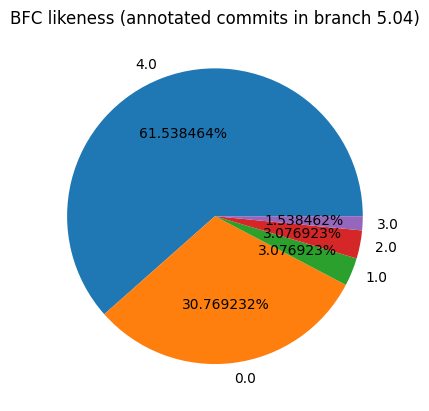

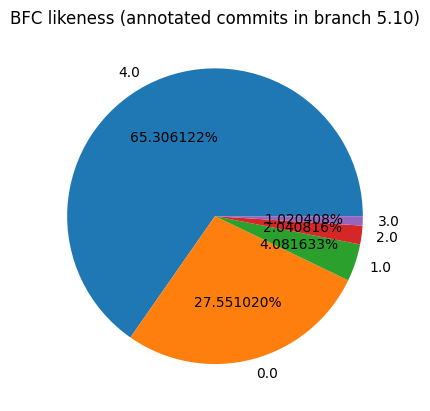

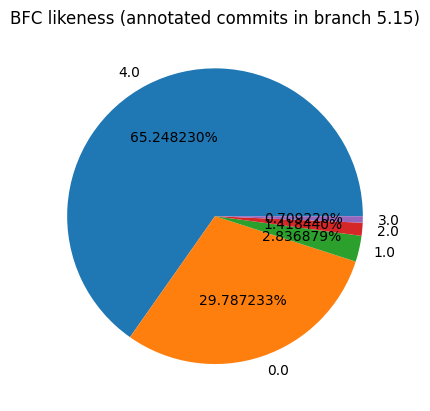

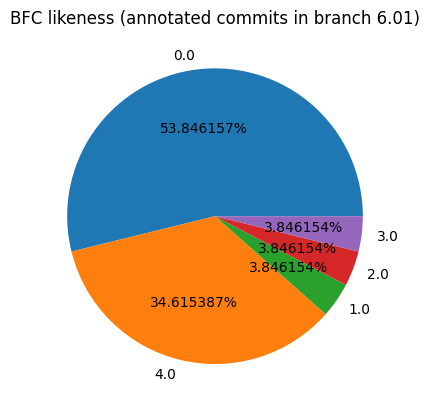

In [316]:
for branch in bfc_counts.index.levels[0]:
    plt.figure()
    plt.pie(bfc_counts.loc[branch], labels=bfc_counts.loc[branch].index, autopct='%1.1f%%')
    plt.title(f'BFC likeness (annotated commits in branch {branch})')
    #plt.show()
    plt.savefig(os.path.join("figs", f"upstream_commits_annotated_bfc_{branch}.eps"))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 2000x600 with 0 Axes>

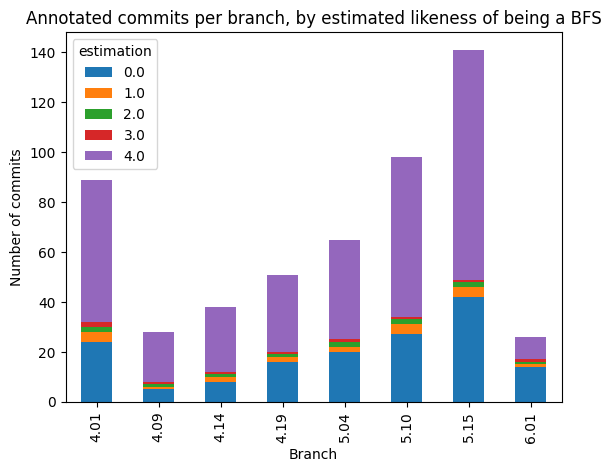

<Figure size 2000x600 with 0 Axes>

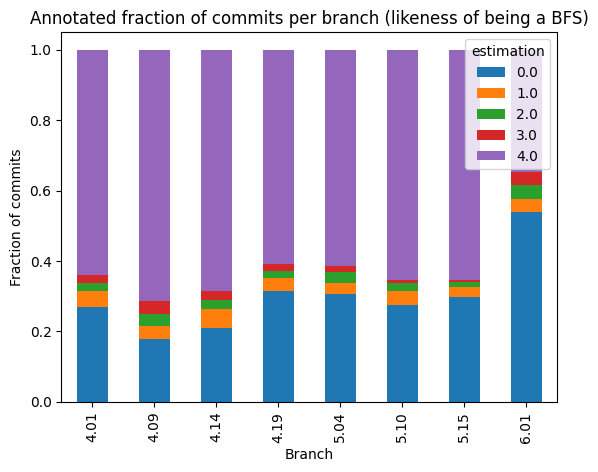

In [340]:
plt.figure(figsize=(20, 6))
bfc_counts.unstack().plot(kind="bar", stacked=True)
plt.title("Annotated commits per branch, by estimated likeness of being a BFS")
plt.xlabel("Branch")
plt.ylabel("Number of commits")
#plt.show()
plt.savefig(os.path.join("figs", f"annotated_commits_branch_bfs.eps"))

plt.figure(figsize=(20, 6))
bfc_fractions.unstack().plot(kind="bar", stacked=True)
plt.title("Annotated fraction of commits per branch (likeness of being a BFS)")
plt.xlabel("Branch")
plt.ylabel("Fraction of commits")
#plt.show()
plt.savefig(os.path.join("figs", f"annotated_commits_branch_bfs_fraction.eps"))

In [318]:
from IPython.display import HTML

#HTML(LTS_annotated.to_html(escape=False))
#HTML(LTS_annotated.loc[LTS_annotated['estimation'] < 4, :].to_html(escape=False))

# Produce a dataframe with annotations and review for relevant cols

In [327]:
annotations_dir = "comparison-3"
annotations_dir = "commit-annotator"
reviews_dir = "comparison-3"

annot_files = ['annotations_Michel.csv', 'annotations_Abhishek.csv', 'annotations_David.csv']
annot_cols = ['bfc', 'bpc', 'prc', 'nfc']
reviewer_file = 'review_jesus.csv'

def load_annotations(files, file_reviewer, cols):
    """Read annotation files and produce a dataframe with relevant columns"""
        
    def get_cols(results_df, cols):
        """Get columnos from dataframe (in addition to 'hash', which is always got)"""
        
        df = results_df[['hash'] + cols]
        return df
    
    def read_csv_from_dir(dirname, filename, cols):
        cols_converters = {col: int for col in cols}
        results = pd.read_csv(os.path.join('..', dirname, filename),
                              converters=cols_converters)
        return results
    
    def rename_cols (cols, suffix):
        """Return new column names (with suffix)"""
        return {col: col + suffix for col in cols}

    df_list = []
    for file in files:
        csv_df = read_csv_from_dir(annotations_dir, file, cols)
        df = get_cols(csv_df, cols)
        df_list.append(df)

    if len(df_list) == 1:
        data_df = df_list[0]
        data_df = data_df.rename(columns=rename_cols(cols, 'A'))
    else:
        data_df = pd.merge(df_list[0], df_list[1], on='hash', how='inner', suffixes=('A', 'B'))
        if len(df_list) > 2:            
            for i, df in enumerate(df_list[2:]):
                suffix = chr(ord('C') + i)
                data_df = pd.merge(data_df, df, on='hash', how='inner', suffixes=('', suffix))
                data_df = data_df.rename(columns=rename_cols(cols, suffix))

    csv_df = read_csv_from_dir(reviews_dir, file_reviewer, cols)
    df = get_cols(csv_df, cols)
    data_df = pd.merge(data_df, df, on='hash', how='left')
    data_df = data_df.rename(columns=rename_cols(cols, 'R'))

    return data_df

data_df = load_annotations(annot_files, reviewer_file, annot_cols)
data_df

,hash,bfcA,bpcA,prcA,nfcA,bfcB,bpcB,prcB,nfcB,bfcC,bpcC,prcC,nfcC,bfcR,bpcR,prcR,nfcR
0,0704a8586f,0,0,4,0,0,3,4,0,0,0,4,0,0.0,0.0,3.0,0.0
1,c5e97ed154,0,0,4,0,0,4,4,0,0,0,4,0,0.0,0.0,4.0,0.0
2,4f9f531e15,0,1,4,0,0,4,4,0,0,1,4,0,0.0,0.0,4.0,0.0
3,258030acc9,0,0,4,0,0,4,4,0,0,0,4,0,0.0,0.0,4.0,0.0
4,5b2c5540b8,4,1,0,0,4,0,0,0,3,2,0,0,4.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,b02ba9ed7c,0,0,4,0,0,0,4,0,0,0,4,0,NaN,NaN,NaN,NaN
907,868695e43b,0,0,0,4,0,0,0,4,0,0,0,4,NaN,NaN,NaN,NaN
908,7afc1f6977,0,0,0,4,0,0,0,4,0,0,0,4,NaN,NaN,NaN,NaN
909,ac686cbc6f,0,0,3,4,0,0,0,4,0,0,3,4,NaN,NaN,NaN,NaN


# Compute estimations

In [415]:
import math

def estimation(A, B, C, R):
    if math.isnan(R):
        return round((A + B + C) / 3)
    else:
        return int(R)

def estimation_col(df, cols):
    """Estimation for a column, for example, bfc"""
    for col in cols:
        data_df[col] = data_df.apply(lambda row: estimation(row[col+'A'], row[col+'B'], row[col+'C'], row[col+'R']),
                                     axis=1)
    return data_df

data_df = estimation_col(data_df, annot_cols)

# Produce an estimation based on the higher from bfc, bpc, prc, nfc:
data_df['kind'] = data_df[annot_cols].apply(lambda row: row.idxmax(), axis=1)

kind_counts = data_df['kind'].value_counts()
kind_fractions = data_df['kind'].value_counts(normalize=True)
print(kind_counts, kind_fractions)

kind
prc    446
bfc    204
nfc    145
bpc    116
Name: count, dtype: int64 kind
prc    0.489572
bfc    0.223930
nfc    0.159166
bpc    0.127333
Name: proportion, dtype: float64


In [423]:
LTS_kinds = pd.merge(LTS_commits, data_df, on='hash', how='left')
LTS_kinds = LTS_kinds[LTS_kinds['kind'].notna()]
#LTS_kinds

In [349]:
kinds_counts = LTS_kinds.groupby('branch')['kind'].value_counts()
kinds_fractions = LTS_kinds.groupby('branch')['kind'].value_counts(normalize=True)
display(kinds_counts, kinds_fractions)

branch  kind
4.01    bfc     61
        bpc     15
        prc      8
        nfc      5
4.09    bfc     22
        bpc      3
        prc      2
        nfc      1
4.14    bfc     28
        bpc      5
        prc      3
        nfc      2
4.19    bfc     33
        bpc     10
        prc      5
        nfc      3
5.04    bfc     42
        bpc     13
        prc      7
        nfc      3
5.10    bfc     66
        bpc     16
        prc     11
        nfc      5
5.15    bfc     94
        prc     21
        bpc     19
        nfc      7
6.01    bfc     10
        prc      8
        bpc      6
        nfc      2
Name: count, dtype: int64

branch  kind
4.01    bfc     0.685393
        bpc     0.168539
        prc     0.089888
        nfc     0.056180
4.09    bfc     0.785714
        bpc     0.107143
        prc     0.071429
        nfc     0.035714
4.14    bfc     0.736842
        bpc     0.131579
        prc     0.078947
        nfc     0.052632
4.19    bfc     0.647059
        bpc     0.196078
        prc     0.098039
        nfc     0.058824
5.04    bfc     0.646154
        bpc     0.200000
        prc     0.107692
        nfc     0.046154
5.10    bfc     0.673469
        bpc     0.163265
        prc     0.112245
        nfc     0.051020
5.15    bfc     0.666667
        prc     0.148936
        bpc     0.134752
        nfc     0.049645
6.01    bfc     0.384615
        prc     0.307692
        bpc     0.230769
        nfc     0.076923
Name: proportion, dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


kind,bfc,bpc,nfc,prc
branch,,,,
4.01,61,15,5,8
4.09,22,3,1,2
4.14,28,5,2,3
4.19,33,10,3,5
5.04,42,13,3,7
5.10,66,16,5,11
5.15,94,19,7,21
6.01,10,6,2,8


<Figure size 2000x600 with 0 Axes>

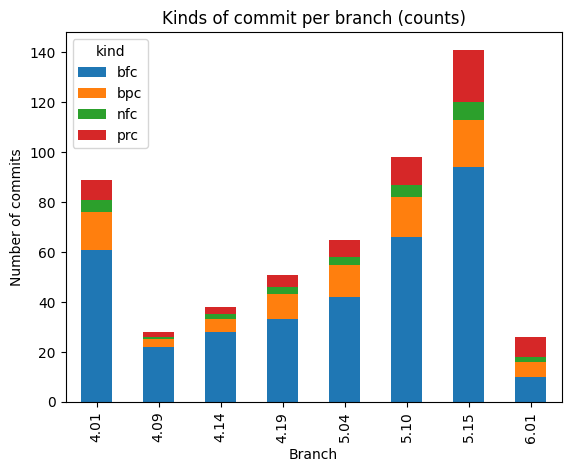

<Figure size 2000x600 with 0 Axes>

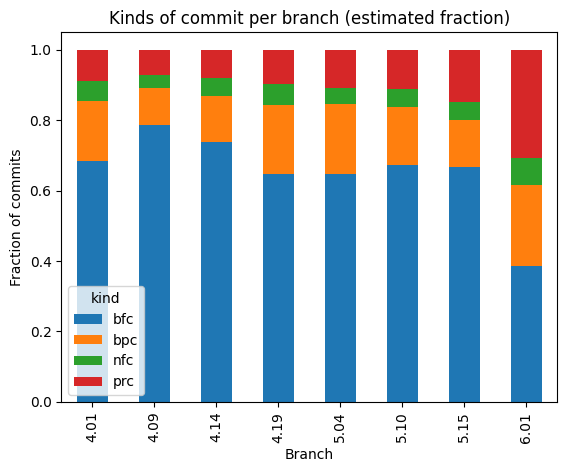

In [445]:
plt.figure(figsize=(20, 6))
kinds_counts.unstack().plot(kind="bar", stacked=True)
plt.title("Kinds of commit per branch (counts)")
plt.xlabel("Branch")
plt.ylabel("Number of commits")
#plt.show()
plt.savefig(os.path.join("figs", f"annotated_commits_branch_kind.eps"))

plt.figure(figsize=(20, 6))
kinds_fractions.unstack().plot(kind="bar", stacked=True)
plt.title("Kinds of commit per branch (estimated fraction)")
plt.xlabel("Branch")
plt.ylabel("Fraction of commits")
#plt.show()
plt.savefig(os.path.join("figs", f"annotated_commits_branch_kind_fraction.eps"))

In [368]:
branch_counts = LTS_commits['branch'].value_counts()
with open (os.path.join('tables','kind_counts_branch.tex'), 'w') as f:
    print('\\begin{tabular}{llllll}', file=f)
    print("Branch & total & BFC & BPC & PRC & NFC \\\\ \\hline", file=f)
    for branch, commits in sorted(branch_counts.items()):
        print(f"{branch} & {commits} ", file=f, end="")
        try:
            for kind, fraction in kinds_fractions[branch].items():
                print(f"& {round(commits*fraction)} ", file=f, end="")
        except KeyError:
            # 4.04 is raising KeyError... CHECK this!
            pass
        print("\\\\", file=f)
    print('\\end{tabular}', file=f)
branch_counts

branch
4.01    73060
4.19    28845
5.10    27581
5.04    27291
4.14    26585
5.15    24638
4.09    22642
6.01    18885
4.04    18356
6.06     9577
Name: count, dtype: int64

# Kind of commits per date, for each branch

TODO:
* Kinds of commits per quarter
* Time from commit in upstream kernel to commit in branch (by branch, by time in branch)
* What happens in 4.1 to have commits before 2022 (the sample we have is supposed to be from 2022)

In [447]:
LTS_kinds_date = pd.merge(LTS_kinds, LTS_dates, on=['branch', 'minor'], how='left')
LTS_kinds_date['month'] = LTS_kinds_date['date'].str[0:7]
LTS_kinds_date['year'] = LTS_kinds_date['date'].str[0:7]
branch_data_kind_counts = LTS_kinds_date.groupby(['branch', 'year'])['kind'].value_counts()
branch_data_kind_fractions = LTS_kinds_date.groupby(['branch', 'year'])['kind'].value_counts(normalize=True)
display(branch_data_kind_counts, branch_data_kind_fractions)
#LTS_kinds_date

branch  year     kind
4.01    2021-04  bfc     2
        2021-05  bfc     1
        2021-06  bfc     7
                 bpc     1
                 prc     1
                        ..
6.01    2024-07  prc     1
        2024-08  bfc     4
                 prc     2
                 bpc     1
                 nfc     1
Name: count, Length: 263, dtype: int64

branch  year     kind
4.01    2021-04  bfc     1.000000
        2021-05  bfc     1.000000
        2021-06  bfc     0.777778
                 bpc     0.111111
                 prc     0.111111
                           ...   
6.01    2024-07  prc     0.100000
        2024-08  bfc     0.500000
                 prc     0.250000
                 bpc     0.125000
                 nfc     0.125000
Name: proportion, Length: 263, dtype: float64

4.01


<Figure size 2000x600 with 0 Axes>

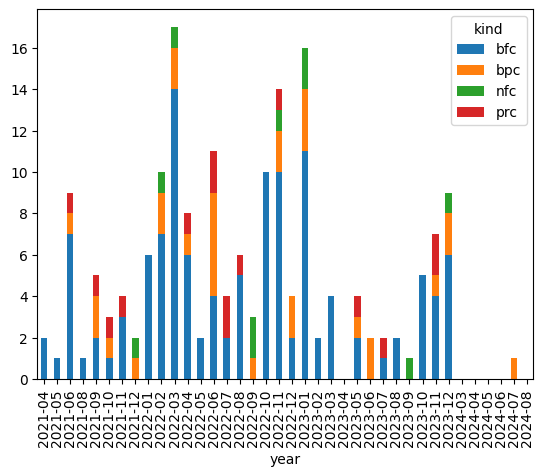

4.09


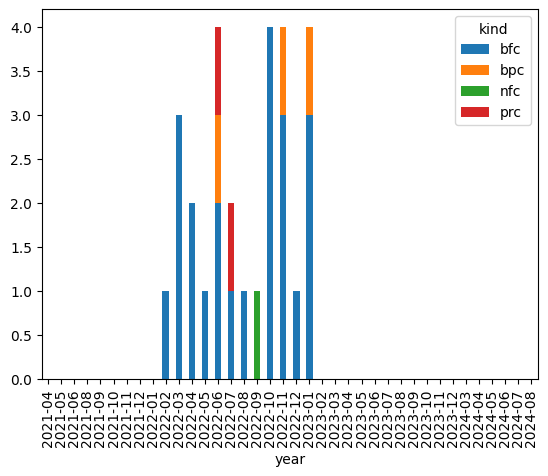

4.14


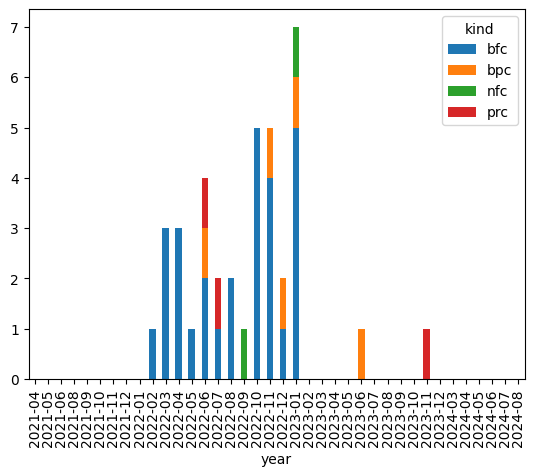

4.19


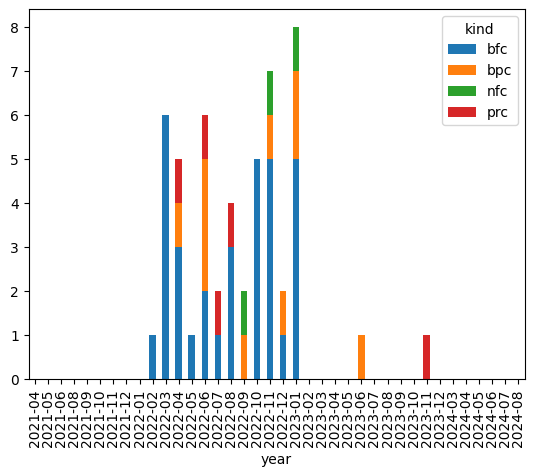

5.04


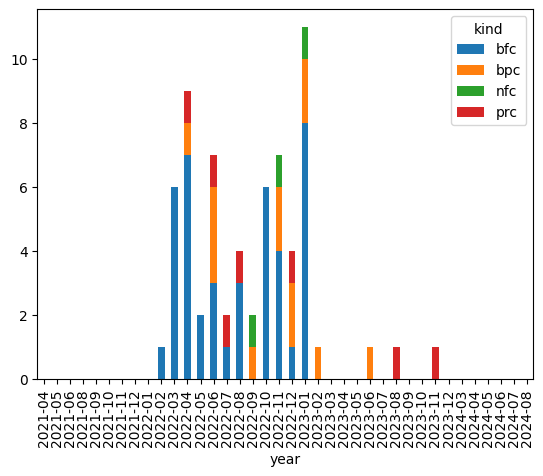

5.10


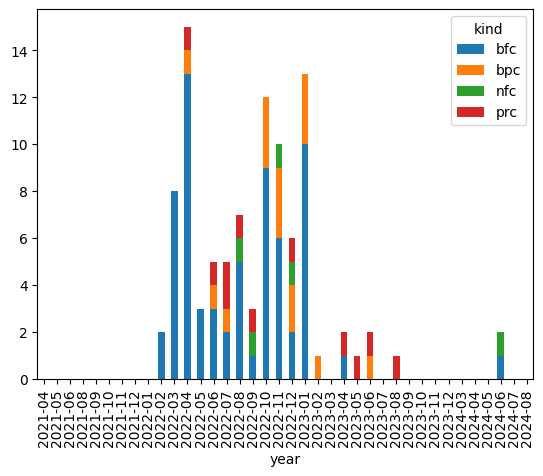

5.15


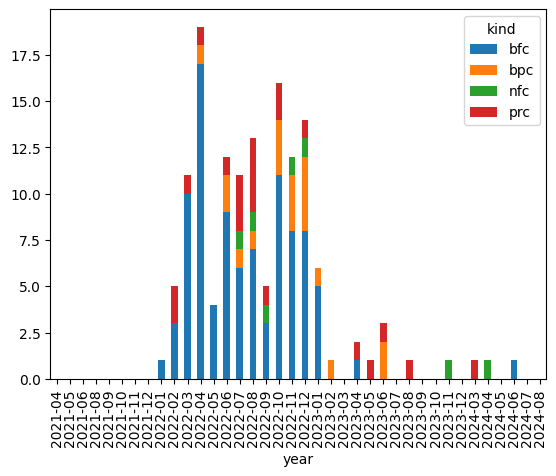

6.01


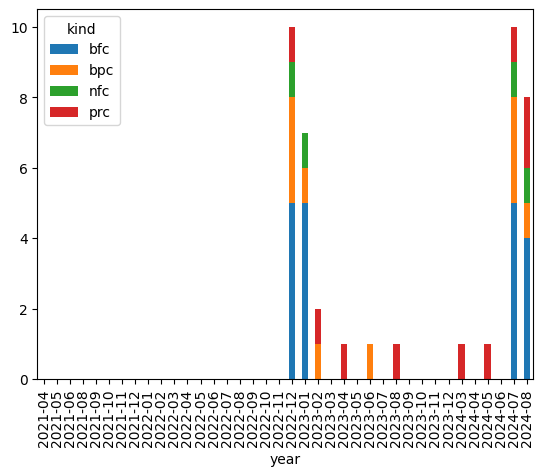

In [450]:
plt.figure(figsize=(20, 6))
branch_data_kind_counts_unstacked = branch_data_kind_counts.unstack('branch')
for branch, series in branch_data_kind_counts_unstacked.items():
    print(branch)
    series.unstack().plot(kind="bar", stacked=True)
    plt.show()
#branch_data_kind_counts_unstacked
#kinds_counts.unstack().plot(kind="bar", stacked=True)
#plt.title("Kinds of commit per branch (counts)")
#plt.xlabel("Branch")
#plt.ylabel("Number of commits")
#plt.show()
#plt.savefig(os.path.join("figs", f"annotated_commits_branch_kind.eps"))

#plt.figure(figsize=(20, 6))
#kinds_fractions.unstack().plot(kind="bar", stacked=True)
#plt.title("Kinds of commit per branch (estimated fraction)")
#plt.xlabel("Branch")
#plt.ylabel("Fraction of commits")
#plt.show()
#plt.savefig(os.path.join("figs", f"annotated_commits_branch_kind_fraction.eps"))